<a href="https://colab.research.google.com/github/YonggunJung/colab/blob/main/1149%EC%98%88%EC%B8%A1DLotto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
win = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/로또/data/jlotto.csv', delimiter = ',')
win

array([[ 4.,  7., 17., 18., 38., 44.],
       [ 8., 12., 13., 29., 33., 42.],
       [ 3.,  7., 14., 15., 22., 38.],
       ...,
       [ 6., 11., 17., 19., 40., 43.],
       [ 7., 11., 24., 26., 27., 37.],
       [ 3.,  6., 13., 15., 16., 22.]])

In [4]:
xn = len(win)

In [5]:
# 숫자를 원핫 인코딩으로 변환
def n2o(numbers):

  oh = np.zeros(45)  # 45개의 빈 칸 만들기

  for i in range(6):            # 6개의 당첨번호를 반복
      oh[int(numbers[i])-1] = 1   # 번호는 1부터 시작하고 인덱스는 0부터 시작하니 1을 빼줌

  return oh

# 원핫 인코딩을 숫자로 변환
def o2n(oh):

  numbers = []

  for i in range(len(oh)):
    if oh[i] == 1:           # oh[i]이 1 이면 해당 번호를 출력
      numbers.append(i+1)    # 인덱스 보다 숫자가 1크니까 1더해줌 출력

  return numbers

In [6]:
numbers = win[: , :]  # 이게 문제라서 못 하겠음ㅠ 데이터 프레임이 문제인가?
                      # 데이터 프레임으로 안열고 넘파이 텍스트 파일로 가져오니 됨
ohs = list(map(n2o, numbers))

xs = ohs[0:xn -1]
ys = ohs[1:xn]

# 원핫 인코딩 확인
print('ohs')
print('x[0] :' + str(xs[0]))
print('y[0] :' + str(ys[0]))

# 번호 확인
print('numbers')
print('x[0] :' + str(o2n(xs[0])))
print('y[0] :' + str(o2n(ys[0])))

ohs
x[0] :[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
y[0] :[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
x[0] :[4, 7, 17, 18, 38, 44]
y[0] :[8, 12, 13, 29, 33, 42]


In [7]:
train = (0, int(len(win)*0.6))
val = (int(len(win)*0.6), int(len(win)*0.8))
test = (int(len(win)*0.8), len(win))

print('train : {0}, val : {1}, test : {2}'.format(train, val, test))

train : (0, 688), val : (688, 918), test : (918, 1148)


In [8]:
# !pip install tensorflow==2.8.0

In [9]:
!pip uninstall tensorflow protobuf -y
!pip install tensorflow==2.12.0 protobuf==3.20.3

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have te

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델 정의
model = keras.Sequential([
    keras.layers.LSTM(128,
                      batch_input_shape = (1, 1, 45),
                      return_sequences = False,
                      stateful = True),
    keras.layers.Dense(45, activation = 'sigmoid')
])

# 모델 컴파일
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [11]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(16):
    model.reset_states()  # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []

    for i in range(train[0], train[1]):

        xss = xs[i].reshape(1, 1, 45)
        yss = ys[i].reshape(1, 45)

        loss, acc = model.train_on_batch(xss, yss) # 배치만큼 모델에 학습

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val[0], val[1]):

        xss = xs[i].reshape(1, 1, 45)
        yss = ys[i].reshape(1, 45)

        loss, acc = model.test_on_batch(xss, yss) # 배치만큼 모델에 입력하여 나온 결과를 정답과 비교함

        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch{0:4d}, acc {1:0.3f}, loss {2: 0.3f}, val_acc {3:0.3f}, val_loss {4:0.3f}'.format(epoch,
                                                                                                  np.mean(batch_train_acc),
                                                                                                  np.mean(batch_train_loss),
                                                                                                  np.mean(batch_val_acc),
                                                                                                  np.mean(batch_val_loss)))

epoch   0, acc 0.022, loss  0.410, val_acc 0.000, val_loss 0.399
epoch   1, acc 0.023, loss  0.397, val_acc 0.000, val_loss 0.398
epoch   2, acc 0.023, loss  0.394, val_acc 0.000, val_loss 0.398
epoch   3, acc 0.035, loss  0.392, val_acc 0.000, val_loss 0.398
epoch   4, acc 0.036, loss  0.389, val_acc 0.004, val_loss 0.399
epoch   5, acc 0.041, loss  0.384, val_acc 0.009, val_loss 0.402
epoch   6, acc 0.054, loss  0.379, val_acc 0.017, val_loss 0.405
epoch   7, acc 0.054, loss  0.374, val_acc 0.030, val_loss 0.409
epoch   8, acc 0.054, loss  0.368, val_acc 0.022, val_loss 0.412
epoch   9, acc 0.061, loss  0.362, val_acc 0.030, val_loss 0.416
epoch  10, acc 0.073, loss  0.356, val_acc 0.030, val_loss 0.419
epoch  11, acc 0.089, loss  0.349, val_acc 0.030, val_loss 0.423
epoch  12, acc 0.103, loss  0.342, val_acc 0.030, val_loss 0.427
epoch  13, acc 0.105, loss  0.335, val_acc 0.030, val_loss 0.431
epoch  14, acc 0.113, loss  0.326, val_acc 0.026, val_loss 0.437
epoch  15, acc 0.124, los

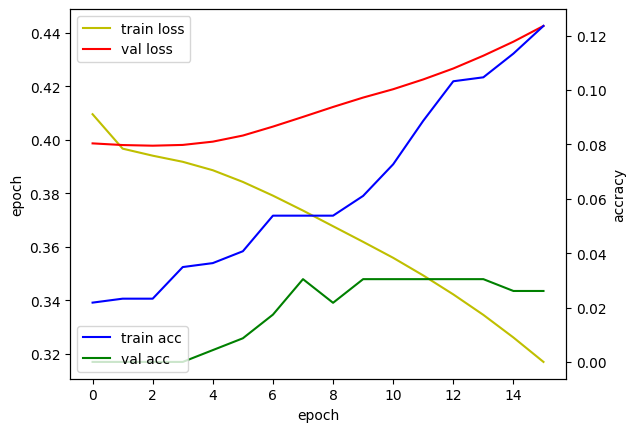

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label = 'train loss')
loss_ax.plot(val_loss, 'r', label = 'val loss')

acc_ax.plot(train_acc, 'b', label = 'train acc')
acc_ax.plot(val_acc, 'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('epoch')
acc_ax.set_ylabel('accracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()
# 이미 학습은 의미가 없다는 결론이 나옴

In [13]:
# 모든 데이터를 학습용으로 사용
for epoch in range(45):

    model.reset_states()  # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(xs)):

      xss = xs[i].reshape(1, 1, 45)
      yss - ys[i].reshape(1, 45)

      loss, acc = model.train_on_batch(xss, yss) # 배치만큼 모델에 학습

      batch_train_loss.append(loss)
      batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch{0:4d}, acc {1:0.3f}, loss {2: 0.3f}'.format(epoch,
                                                            np.mean(batch_train_acc),
                                                            np.mean(batch_train_loss)
                                                            ))



epoch   0, acc 0.131, loss  0.126
epoch   1, acc 0.122, loss  0.078
epoch   2, acc 0.116, loss  0.056
epoch   3, acc 0.115, loss  0.044
epoch   4, acc 0.121, loss  0.036
epoch   5, acc 0.127, loss  0.031
epoch   6, acc 0.130, loss  0.027
epoch   7, acc 0.130, loss  0.024
epoch   8, acc 0.126, loss  0.021
epoch   9, acc 0.118, loss  0.019
epoch  10, acc 0.109, loss  0.017
epoch  11, acc 0.101, loss  0.016
epoch  12, acc 0.094, loss  0.015
epoch  13, acc 0.088, loss  0.014
epoch  14, acc 0.082, loss  0.013
epoch  15, acc 0.077, loss  0.012
epoch  16, acc 0.073, loss  0.011
epoch  17, acc 0.069, loss  0.011
epoch  18, acc 0.065, loss  0.010
epoch  19, acc 0.062, loss  0.010
epoch  20, acc 0.059, loss  0.009
epoch  21, acc 0.057, loss  0.009
epoch  22, acc 0.054, loss  0.009
epoch  23, acc 0.052, loss  0.008
epoch  24, acc 0.050, loss  0.008
epoch  25, acc 0.048, loss  0.008
epoch  26, acc 0.046, loss  0.007
epoch  27, acc 0.045, loss  0.007
epoch  28, acc 0.043, loss  0.007
epoch  29, acc

In [14]:
# 다음회 예측

print('receive numbers')

xss = xs[-1].reshape(1, 1, 45)

pred = model.predict_on_batch(xss)
pred

luck = list(map(o2n, pred))
luck

# list_number = []

# for n in range(6):
#   numbers =pred
  # numbers.sort()
  # print('{0} : {1}'.format(n, numbers))
  # list_numbers.append(numbers)

receive numbers


[[24, 27, 28, 30, 36, 39]]